# Tabular Rates and Urca Reactions
pynucastro can generate networks that include tabulated rates such as beta-decays and electron captures. These rates can be very important to applications and pynucastro allows one to seemlessly incorporate them into networks made of Reaclib rates

In [1]:
import pynucastro as pyna
import matplotlib.pyplot as plt

After importing pynucastro we can simply create a list of the rate files we want to include. In this example we represent some simple carbon burning with the addition of the A = 23 Urca reactions (`"na23--ne23-toki", "ne23--na23-toki"`). This is a pair of reactions consisting of:

$$ {}^{23}\mathrm{Ne}  \rightarrow {}^{23}\mathrm{Na} +\mathrm{e}^- + \bar{\nu}_e $$
$$ {}^{23}\mathrm{Na} + \mathrm{e}^- \rightarrow {}^{23}\mathrm{Ne} + \nu_e $$

We can then plot the resulting network to see it's contents more clearly.

First we retrieve the reaclib rates we want for the carbon burning. We do this by using `RateFilter` to select the desired rates from a snapshot of the full ReacLib Library. In the end we form a library we will call `cburn_lib`

In [2]:
full_lib = pyna.ReacLibLibrary()

# get desired reaclib rates
c12_c12_filter = pyna.RateFilter(reactants=['c12', 'c12']) 
c12_o16_filter = pyna.RateFilter(reactants=['c12', 'he4'], products=['o16'])
n_decay_filter = pyna.RateFilter(reactants=['n'], products=['p'])
cburn_lib = full_lib.filter(c12_c12_filter) + full_lib.filter(c12_o16_filter) + full_lib.filter(n_decay_filter)

print(cburn_lib)


n ⟶ p + e⁻ + 𝜈                 [Q =   0.78 MeV] (n --> p <wc12_reaclib_weak_>)
C12 + He4 ⟶ O16 + 𝛾            [Q =   7.16 MeV] (c12 + he4 --> o16 <nac2_reaclib__>)
C12 + C12 ⟶ He4 + Ne20         [Q =   4.62 MeV] (c12 + c12 --> he4 + ne20 <cf88_reaclib__>)
C12 + C12 ⟶ p + Na23           [Q =   2.24 MeV] (c12 + c12 --> p + na23 <cf88_reaclib__>)
C12 + C12 ⟶ n + Mg23           [Q =  -2.60 MeV] (c12 + c12 --> n + mg23 <cf88_reaclib__reverse>)


Now we grab the Tabulated rates we want for the A=23 reaction. We do this by using the `linking_nuclei` feature. This grabs all rates in the `TabularLibrary` that link the listed nuclei (in this case `'na23'` and `'ne23'`)

In [3]:
# get desired Tabular rates
tabular_lib = pyna.TabularLibrary()
urca23_nuc = ['na23', 'ne23']
urca_lib = tabular_lib.linking_nuclei(urca23_nuc)
urca_lib.get_rates()

[Ne23 ⟶ Na23 + e⁻ + 𝜈, Na23 + e⁻ ⟶ Ne23 + 𝜈]

Now we can combine the ReacLib library (`cburn_lib`) with our Tabular Library (`urca_lib`) to collect all the rates we want and form a network we'll call `urca_net`. To visualize all the rates, we can quickly generate a plot

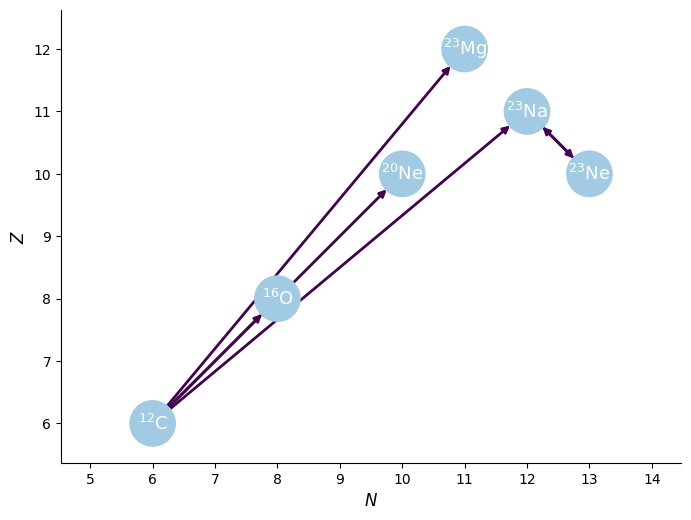

In [4]:
urca_net = pyna.RateCollection(libraries=[cburn_lib, urca_lib])
urca_net.plot()

To see an example of how this network would function in a White Dwarf, we define a composition. We choose a primarily Carbon-Oxygen 40%-60% composition with small amounts of Na23 and Ne23. Then we only need to specify a temperature and density, and pynucastro can calculate the rates and show us what rates are most important during these conditions. 

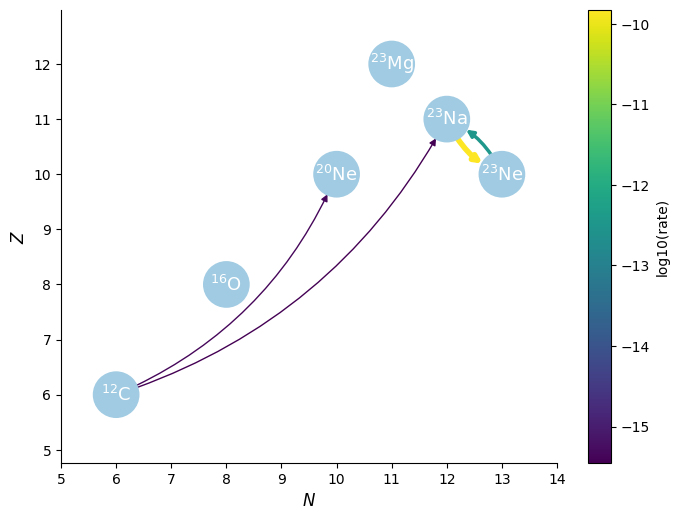

In [5]:
comp = pyna.Composition(urca_net.unique_nuclei)
xvals = [0., 0., 0., 0.3995, 0.5995, 0., 5e-4, 5e-4, 0.]
names = ['n', 'p', 'he4', 'c12', 'o16', 'ne20', 'ne23', 'na23', 'mg23']

for n, X in zip(names, xvals):
    comp.set_nuc(n, X)

comp.normalize()
rho = 2e9 # g/cm**3
temp = 4.5e8 # K
urca_net.plot(comp=comp, rho=rho, T=temp, curved_edges=True, ydot_cutoff_value=1e-20)

Notice in this example, we took a density and temperature such that the Urca reactions would be most important. Though we can also see the rates are unbalanced with a higher rate of electron captures than beta decays.

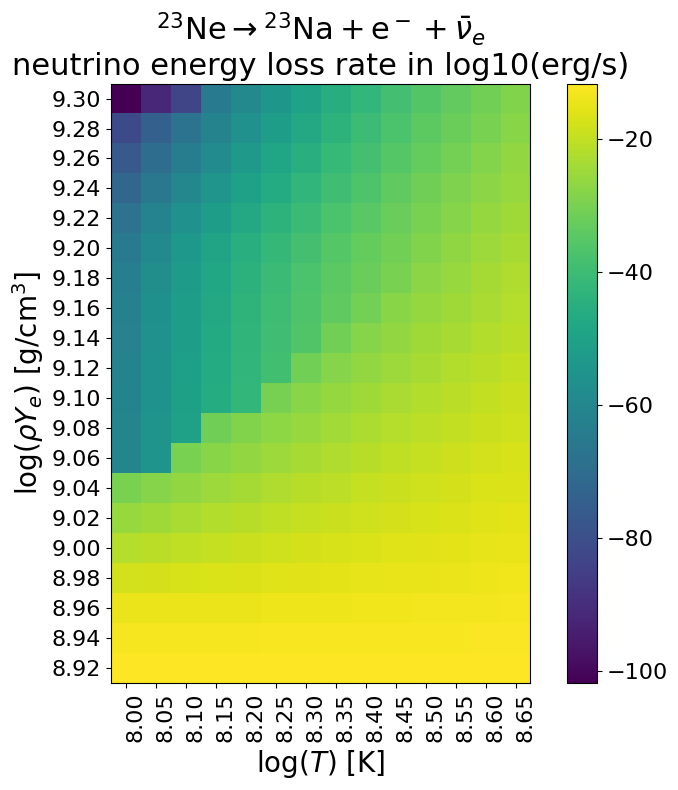

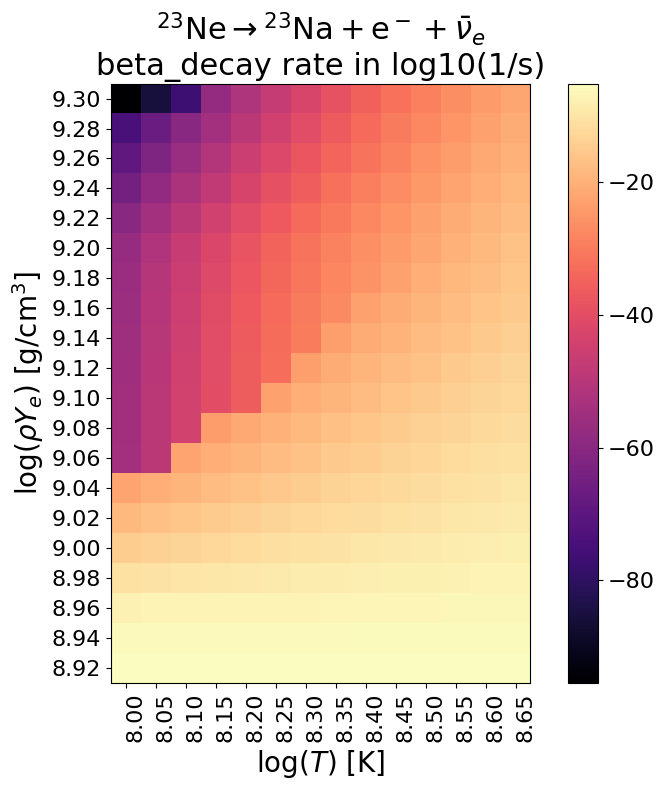

In [6]:
plt.rcParams["axes.titlesize"] = 22
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16


r = pyna.rates.TabularRate("ne23--na23-toki")

size=(8,8)

fig_nu = r.plot(Tmin=1e8, Tmax=5e8, rhoYmin=8e8, rhoYmax=2.e9, color_field='nu_loss',figsize=size)
fig_rate = r.plot(Tmin=1e8, Tmax=5e8, rhoYmin=8e8, rhoYmax=2.e9, color_field='rate',figsize=size)

fig_nu.tight_layout()
fig_rate.tight_layout()

fig_nu.savefig("ne23_na23_nu_loss.pdf", bbox_inches='tight')
fig_rate.savefig("ne23_na23_rate.pdf", bbox_inches='tight')